In [1]:
import sys
import os
import shutil
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;
# for this course we use locally stored version of pyemu and flopy to avoid version conflicts
import pyemu
import flopy

sys.path.insert(0,"..")
import herebedragons as hbd

### Create temp directory so we don't break anything

In [2]:
# folder containing original model files
org_d = os.path.join('..', 'input-files')

# a dir to hold a copy of the org model files
tmp_d = os.path.join('..','peterson_mf6')

if os.path.exists(tmp_d):
    shutil.rmtree(tmp_d)
shutil.copytree(org_d,tmp_d)

# get executables
hbd.prep_bins(tmp_d)
# get dependency folders
#hbd.prep_deps(tmp_d)

In [3]:
# load simulation
sim = flopy.mf6.MFSimulation.load(sim_ws=tmp_d)
# load flow model
gwf = sim.get_model()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package riv...
    loading package obs...
    loading package wel...
    loading package chd...
    loading package sto...
    loading package rch...
    loading package oc...
    loading package rch...
  loading model gwt6...
    loading package dis...
    loading package ic...
    loading package adv...
    loading package dsp...
    loading package mst...
    loading package ist...
    loading package ssm...
    loading package obs...
    loading package oc...
  loading model gwt6...
    loading package dis...
    loading package ic...
    loading package adv...
    loading package dsp...
    loading package ist...
    loading package mst...
    loading package ssm...
    loading package obs...
    loading package oc...
  loading model gwt6...
    loading package dis...
    loading packag

### Spatial Reference

Now we can instantiate a SpatialReference. This will later be passed to PstFrom to assist with spatially locating parameters (e.g. pilot points and/or cell-by-cell parameters). You can also use the flopy modelgrid class instance that is attached to the simulation, but SpatialReference is cleaner and faster for structured grids...

In [4]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(tmp_d, "peterson_flow.nam"),
        delr=gwf.dis.delr.array, delc=gwf.dis.delc.array)
sr

   could not remove start_datetime


xul:0; yul:19440; rotation:0; proj4_str:None; units:meters; lenuni:2; length_multiplier:1.0

### Instantiate PstFrom

Now we can start to construct the PEST(++) interface by instantiating a PstFrom class instance. There are a few things that we need to specify up front:

the folder in which we currently have model files (e.g. tmp_d). PstFrom will copy all the files from this directory into a new "template" folder.

template folder: this is a folder in which the PEST dataset will be constructed - this folder will hold the model files plus all of the files needed to run PEST(++). This folder/dataset will form the template for subsequent deployment of PEST(++).

longnames: for backwards compatibility with PEST and PEST_HP (i.e. non-PEST++ versions), which have upper limits to parameter/observation names (PEST++ does not). Setting this value to False is only recommended if required.

Whether the model is zero based or not.

(optional) the spatial reference, as previously discussed. This is only required if using pyEMU to define parameter spatial correlation. Alternatively, you can define these yourself or use utilities available in the PEST-suite.

In [5]:
# specify a template directory (i.e. the PstFrom working folder)
template_ws = os.path.join('..','peterson_template')
start_datetime="1-1-1970"
# instantiate PstFrom
pf = pyemu.utils.PstFrom(original_d=tmp_d, # where the model is stored
                            new_d=template_ws, # the PEST template folder
                            remove_existing=True, # ensures a clean start
                            longnames=True, # set False if using PEST/PEST_HP
                            spatial_reference=sr, #the spatial reference we generated earlier
                            zero_based=False, # does the MODEL use zero based indices? For example, MODFLOW does NOT
                            start_datetime=start_datetime, # required when specifying temporal correlation between parameters
                            echo=False) # to stop PstFrom from writting lots of infromation to the notebook; experiment by setting it as True to see the difference; usefull for troubleshooting
     

### Observations

In [6]:
df = pd.read_csv(os.path.join('..', 'output-files','head_obs.csv'),index_col=0)
df.columns = df.columns.str.replace(" ", "")
df.to_csv('../output-files/head_obs.csv')
df.head()
     

,FOUNTAINNO.1,SC01406518ACDT02-MW006,SC01406518CAAMW1-1,SC01406519ABDT04-MW004,SC01406519BBBT01-MW002,SC01406520CDBMW2-4,SC01406527ACB1,SC01406527DDB1BANNING-LEWISRANCHES,SC01406527DDB2,SC01406527DDC1,...,SCO1506602BBBTH-18,SCO1506602BDC,SCO1506602CAA,SCO1506603AAD,SCO1506603BAC,SCO1506604AAA,SCO1506604AABTH-49,SCO1506604ABA2TH-50,SCO1506610BAA,SCO1506611ABCTH-47
time,,,,,,,,,,,,,,,,,,,,,
59.0,1682.008938,1885.455707,1880.476784,1846.441150,1867.342818,1820.508540,1819.618737,1811.985088,1809.927554,1807.807384,...,1774.684131,1766.093697,1764.109938,1768.602674,1761.823488,1763.989972,1762.171530,1762.211240,1749.539323,1748.027540
89.0,1681.974905,1885.462255,1880.499818,1846.617592,1867.418896,1820.666800,1819.803424,1812.116151,1810.104955,1807.958309,...,1774.669078,1766.102305,1764.116961,1768.600017,1761.804051,1763.760061,1762.476564,1762.556356,1749.539900,1748.027649
274.0,1681.873247,1885.508854,1880.638585,1847.974243,1867.743335,1823.289603,1819.821606,1812.459523,1810.563878,1808.437779,...,1773.904142,1765.801899,1764.144266,1768.069533,1761.448278,1763.336524,1762.390345,1762.499652,1749.534359,1748.045605
304.0,1681.815335,1885.505131,1880.617374,1847.998486,1867.676975,1823.745726,1819.825250,1812.494202,1810.620196,1808.503853,...,1773.823395,1765.757825,1764.146199,1768.007516,1761.393172,1763.287701,1762.378165,1762.491362,1749.531093,1748.048874
365.0,1681.780126,1885.510489,1880.600005,1848.736070,1867.586417,1826.001585,1819.829021,1812.577400,1810.728309,1808.626432,...,1773.396564,1765.551692,1764.126777,1767.656459,1761.256686,1763.174787,1762.351467,1762.473243,1749.521342,1748.056918


### Adding Observations

First, we will use the PstFrom.add_observations() method to add observations to our pf object. This method can use list-type files, where the data are organized in column/tabular format with one or more index columns and one or more data columns. This method can also use array-type files, where the data are organized in a 2-D array structure (we will see this one later...)

We are going to tell pf which columns of this file contain observations. Values in these columns will be assigned to observation values.

We can also inform it if there is an index column (or columns). Values in this column will be included in the observation names.

We could also specify which rows to include as observations. But observations are free...so why not keep them all!

Let's add observations from heads.csv. The first column of this file records the time at which the value is simulated. Let's use that as the index column (this becomes useful later on to post-process results). We want all other columns as observation values.

In [7]:
hds_df = pf.add_observations('../output-files/head_obs.csv', # the model output file to read
                            insfile="head_obs.csv.ins", #optional, the instruction file name
                            index_cols="time", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=list(df.columns.values), #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                            prefix="hds") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations
     

In [8]:
hds_df.head()   

,obsnme,obsval,weight,obgnme
oname:hds_otype:lst_usecol:fountainno.1_time:10013,oname:hds_otype:lst_usecol:fountainno.1_time:10013,1680.901492,1.0,oname:hds_otype:lst_usecol:fountainno.1
oname:hds_otype:lst_usecol:fountainno.1_time:10043,oname:hds_otype:lst_usecol:fountainno.1_time:10043,1680.897982,1.0,oname:hds_otype:lst_usecol:fountainno.1
oname:hds_otype:lst_usecol:fountainno.1_time:1005,oname:hds_otype:lst_usecol:fountainno.1_time:1005,1681.077804,1.0,oname:hds_otype:lst_usecol:fountainno.1
oname:hds_otype:lst_usecol:fountainno.1_time:10074,oname:hds_otype:lst_usecol:fountainno.1_time:10074,1680.901185,1.0,oname:hds_otype:lst_usecol:fountainno.1
oname:hds_otype:lst_usecol:fountainno.1_time:10105,oname:hds_otype:lst_usecol:fountainno.1_time:10105,1680.412359,1.0,oname:hds_otype:lst_usecol:fountainno.1


In [9]:
[f for f in os.listdir(template_ws) if f.endswith(".ins")]

['head_obs.csv.ins']

### Add Parameters

Let's start by adding parameters of hydraulic properties that vary in space (but not time) and which are housed in array-type files (e.g. Kh, Kv, Ss, Sy). We will start by demonstrating step-by-step for Kh.

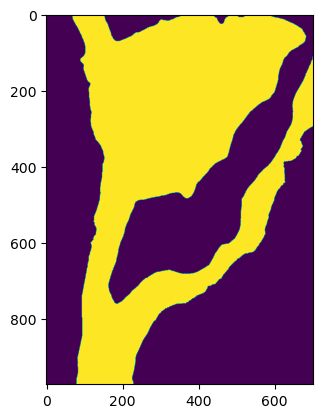

In [14]:
# get the IIDOMAIN array; in our case we only have one layer
ib = gwf.dis.idomain.array[0]
plt.imshow(ib)    

In [10]:
zones_matrix = np.loadtxt(os.path.join('..', 'peterson_template','data-files','rchZones.dat'))
zones = np.where(np.isin(zones_matrix, [2, 3,4,5]), zones_matrix, 0)
zones

array([[0., 0., 0., ..., 2., 2., 2.],
       [0., 0., 0., ..., 2., 2., 2.],
       [0., 0., 0., ..., 2., 2., 2.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
f= os.path.join('..', 'peterson_template','data-files','flow-kfield.dat')
pf.add_parameters(
    f,
    par_type="zone",
    par_name_base="hk",
    zone_array=zones,
    upper_bound=400,
    lower_bound=0.1,
    transform= "log"

)

,parnme,parval1,pargp,tpl_filename,input_filename,partype,partrans,parubnd,parlbnd,dercom,parchglim,scale,offset
pname:hk_inst:0_ptype:zn_pstyle:m_zone:5.0,pname:hk_inst:0_ptype:zn_pstyle:m_zone:5.0,1.0,hk_inst:0,..\peterson_template\hk_inst0_zone.csv.tpl,..\peterson_template\mult\hk_inst0_zone.csv,zone,log,400,0.1,1,factor,1.0,0.0
pname:hk_inst:0_ptype:zn_pstyle:m_zone:2.0,pname:hk_inst:0_ptype:zn_pstyle:m_zone:2.0,1.0,hk_inst:0,..\peterson_template\hk_inst0_zone.csv.tpl,..\peterson_template\mult\hk_inst0_zone.csv,zone,log,400,0.1,1,factor,1.0,0.0
pname:hk_inst:0_ptype:zn_pstyle:m_zone:3.0,pname:hk_inst:0_ptype:zn_pstyle:m_zone:3.0,1.0,hk_inst:0,..\peterson_template\hk_inst0_zone.csv.tpl,..\peterson_template\mult\hk_inst0_zone.csv,zone,log,400,0.1,1,factor,1.0,0.0
pname:hk_inst:0_ptype:zn_pstyle:m_zone:4.0,pname:hk_inst:0_ptype:zn_pstyle:m_zone:4.0,1.0,hk_inst:0,..\peterson_template\hk_inst0_zone.csv.tpl,..\peterson_template\mult\hk_inst0_zone.csv,zone,log,400,0.1,1,factor,1.0,0.0


In [18]:
f= os.path.join('..', 'peterson_template','data-files','flow-recharge-mult.dat')
pf.add_parameters(
    f,
    par_type="zone",
    par_name_base="rch",
    zone_array=zones,
    upper_bound=0.2,
    lower_bound=0,
    transform= "log"
)

,parnme,parval1,pargp,tpl_filename,input_filename,partype,partrans,parubnd,parlbnd,dercom,parchglim,scale,offset
pname:rch_inst:0_ptype:zn_pstyle:m_zone:5.0,pname:rch_inst:0_ptype:zn_pstyle:m_zone:5.0,1.0,rch_inst:0,..\peterson_template\rch_inst0_zone.csv.tpl,..\peterson_template\mult\rch_inst0_zone.csv,zone,log,0.2,0,1,factor,1.0,0.0
pname:rch_inst:0_ptype:zn_pstyle:m_zone:2.0,pname:rch_inst:0_ptype:zn_pstyle:m_zone:2.0,1.0,rch_inst:0,..\peterson_template\rch_inst0_zone.csv.tpl,..\peterson_template\mult\rch_inst0_zone.csv,zone,log,0.2,0,1,factor,1.0,0.0
pname:rch_inst:0_ptype:zn_pstyle:m_zone:3.0,pname:rch_inst:0_ptype:zn_pstyle:m_zone:3.0,1.0,rch_inst:0,..\peterson_template\rch_inst0_zone.csv.tpl,..\peterson_template\mult\rch_inst0_zone.csv,zone,log,0.2,0,1,factor,1.0,0.0
pname:rch_inst:0_ptype:zn_pstyle:m_zone:4.0,pname:rch_inst:0_ptype:zn_pstyle:m_zone:4.0,1.0,rch_inst:0,..\peterson_template\rch_inst0_zone.csv.tpl,..\peterson_template\mult\rch_inst0_zone.csv,zone,log,0.2,0,1,factor,1.0,0.0


In [ ]:
f= os.path.join('..', 'peterson_template','data-files','tran-Kd-pfos.dat')
pf.add_parameters(
    f,
    par_type="zone",
    par_name_base="kd_pfos",
    zone_array=zones,
    upper_bound=10e-6,
    lower_bound=0,
    transform= "log"
)

In [ ]:
f= os.path.join('..', 'peterson_template','data-files','tran-Kd-pfoa.dat')
pf.add_parameters(
    f,
    par_type="zone",
    par_name_base="kd_pfoa",
    zone_array=zones,
    upper_bound=10e-6,
    lower_bound=0,
    transform= "log"
)

In [ ]:
f= os.path.join('..', 'peterson_template','data-files','tran-Kd-pfhxs.dat')
pf.add_parameters(
    f,
    par_type="zone",
    par_name_base="kd_pfhxs",
    zone_array=zones,
    upper_bound=10e-7,
    lower_bound=0,
    transform= "log"
)

In [ ]:
f= os.path.join('..', 'peterson_template','peterson_solutes.ts')
pf.add_parameters(
    f,
    par_type="gri",
    par_name_base="conc",
    zone_array=zones,
    upper_bound=10e-7,
    lower_bound=0,
    transform= "log"
)

In [21]:
pf.add_parameters?

Signature:
pf.add_parameters(
    filenames,
    par_type,
    zone_array=None,
    dist_type='gaussian',
    sigma_range=4.0,
    upper_bound=None,
    lower_bound=None,
    transform=None,
    par_name_base='p',
    index_cols=None,
    use_cols=None,
    use_rows=None,
    pargp=None,
    pp_space=None,
    use_pp_zones=None,
    num_eig_kl=100,
    spatial_reference=None,
    geostruct=None,
    datetime=None,
    mfile_fmt='free',
    mfile_skip=None,
    mfile_sep=None,
    ult_ubound=None,
    ult_lbound=None,
    rebuild_pst=False,
    alt_inst_str='inst',
    comment_char=None,
    par_style='multiplier',
    initial_value=None,
    pp_options=None,
    apply_order=999,
    apply_function=None,
)
Docstring:
Add list or array style model input files to PstFrom object.
This method is the main entry point for adding parameters to the
pest interface

Args:
    filenames (`str`): Model input filenames to parameterize. By default filename should give relative
        loction from to

In [19]:
[f for f in os.listdir(template_ws) if f.endswith(".tpl")]

['hk_inst0_zone.csv.tpl', 'rch_inst0_zone.csv.tpl']

In [15]:
df = pf.add_observations(f,prefix="hk",zone_array=ib)
df

,obsnme,obsval,weight,obgnme
oname:hk_otype:arr_i:0_j:100_zone:1,oname:hk_otype:arr_i:0_j:100_zone:1,158.395,1.0,hk
oname:hk_otype:arr_i:0_j:101_zone:1,oname:hk_otype:arr_i:0_j:101_zone:1,158.395,1.0,hk
oname:hk_otype:arr_i:0_j:102_zone:1,oname:hk_otype:arr_i:0_j:102_zone:1,158.395,1.0,hk
oname:hk_otype:arr_i:0_j:103_zone:1,oname:hk_otype:arr_i:0_j:103_zone:1,158.395,1.0,hk
oname:hk_otype:arr_i:0_j:104_zone:1,oname:hk_otype:arr_i:0_j:104_zone:1,158.395,1.0,hk
...,...,...,...,...
oname:hk_otype:arr_i:9_j:95_zone:1,oname:hk_otype:arr_i:9_j:95_zone:1,158.395,1.0,hk
oname:hk_otype:arr_i:9_j:96_zone:1,oname:hk_otype:arr_i:9_j:96_zone:1,158.395,1.0,hk
oname:hk_otype:arr_i:9_j:97_zone:1,oname:hk_otype:arr_i:9_j:97_zone:1,158.395,1.0,hk
oname:hk_otype:arr_i:9_j:98_zone:1,oname:hk_otype:arr_i:9_j:98_zone:1,158.395,1.0,hk
